In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import colorsys

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}")

def plot_in_time(tensor_array, sampling_rate=100, x_min=-1, y_min=-1, x_max=1, y_max=1, labels=None, plot_size=(700, 500)):
    """
    Plot an array of nx2 PyTorch tensors representing valence-arousal data in an interactive 3D plot using Plotly.
    Each tensor's data is represented by a unique color, with time evolution shown by color opacity.
    
    Args:
    tensor_array (list or torch.Tensor): A list of PyTorch tensors or a single PyTorch tensor, each with shape (n, 2).
                         The first column of each tensor represents valence values,
                         the second column represents arousal values.
    sampling_rate (int): The sampling rate of the data in Hz. Default is 100 Hz.
    x_min, y_min, x_max, y_max: The range for x and y axes.
    labels (list): Optional list of labels for each tensor. If None, default labels will be used.
    plot_size (tuple): Size of the plot in pixels (width, height). Default is (700, 500).
    
    Returns:
    None (displays the interactive plot in the default web browser)
    """
    fig = go.Figure()

    # Convert single tensor to list if necessary
    if isinstance(tensor_array, torch.Tensor):
        tensor_array = [tensor_array]

    num_tensors = len(tensor_array)
    colors = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b in 
              [colorsys.hsv_to_rgb(h, 0.8, 0.8) for h in np.linspace(0, 1, num_tensors, endpoint=False)]]

    time_step = 1 / sampling_rate

    for i, tensor in enumerate(tensor_array):
        # Detach tensor and move to CPU before converting to numpy
        data = tensor.detach().cpu().numpy()
        
        valence = data[:, 0]
        arousal = data[:, 1]
        
        time = np.arange(len(valence)) * time_step

        base_color = np.array([int(c) for c in colors[i].strip('rgb(').strip(')').split(',')])
        color_array = [f'rgba({base_color[0]},{base_color[1]},{base_color[2]},{0.3 + 0.7 * (t / time[-1])})' for t in time]

        scatter_trace = go.Scatter3d(
            x=valence, y=arousal, z=time,
            mode='lines+markers',
            line=dict(color=colors[i], width=3),
            marker=dict(
                size=4,
                color=color_array,
                opacity=0.8
            ),
            name=labels[i] if labels else f'Tensor {i+1}'
        )
        
        fig.add_trace(scatter_trace)

    fig.update_layout(
        scene=dict(
            xaxis_title='X (Valence)',
            yaxis_title='Y (Arousal)',
            zaxis_title='Time (s)',
            xaxis=dict(range=[x_min, x_max]),
            yaxis=dict(range=[y_min, y_max]),
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=0.5)
        ),
        title='Interactive 3D Visualization of Valence-Arousal Data Over Time',
        legend_title_text='Data Series',
        legend=dict(
            itemsizing='constant',
            font=dict(size=10),
            borderwidth=2
        ),
        width=plot_size[0],
        height=plot_size[1]
    )

    fig.show()

def plot_matrix(hidden_state_sequence, num_features_to_plot=None, figsize=(9, 5), title="Plotted Matrix"):
    """
    Plot the evolution of hidden state features over time.
    
    Args:
        hidden_state_sequence (torch.Tensor or np.ndarray): Hidden state sequence of shape (num_time_steps, num_features)
        num_features_to_plot (int, optional): Number of features to plot. If None, all features are plotted.
        figsize (tuple, optional): Figure size (width, height) in inches. Default is (12, 8).
    """
    if isinstance(hidden_state_sequence, torch.Tensor):
        hidden_state_sequence = hidden_state_sequence.cpu().detach().numpy()
    
    num_time_steps, num_features = hidden_state_sequence.shape
    
    if num_features_to_plot is None or num_features_to_plot > num_features:
        num_features_to_plot = num_features
    
    colors = plt.cm.rainbow(np.linspace(0, 1, num_features_to_plot))
    
    plt.figure(figsize=figsize)
    for i in range(num_features_to_plot):
        plt.plot(range(num_time_steps), hidden_state_sequence[:, i], color=colors[i], label=f'Feature {i+1}')
    
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def load_eeg_data_tensor(file_path):
    """
    Load EEG data from a file and convert it to two separate PyTorch tensors:
    one for EEG data and one for labels (valence and arousal).
    
    Args:
    file_path (str): Path to the data file.
    
    Returns:
    tuple: (eeg_data, labels)
        eeg_data (torch.Tensor): A timestepsx1 tensor containing the EEG data.
        labels (torch.Tensor): A timestepsx2 tensor where the first column is valence
                               and the second column is arousal.
    """
    try:
        data = np.loadtxt(file_path, delimiter=',')
        
        tensor_data = torch.tensor(data, dtype=torch.float32)
        
        if tensor_data.shape[1] != 3:
            raise ValueError(f"Expected 3 columns, but got {tensor_data.shape[1]}")
        
        eeg_data = tensor_data[:, 0:1]  # First column
        labels = tensor_data[:, 1:3]    # Second and third columns

        eeg_data = eeg_data.to(device)
        labels = labels.to(device)
        
        return eeg_data, labels
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except ValueError as e:
        print(f"Error: Invalid data format - {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return None, None

class LTC(nn.Module):
    def __init__(self, LTC_layers, MLP_layers, step_size):
        super(LTC, self).__init__()
        
        self.tau = nn.Parameter(torch.empty(1).uniform_(0, 1))
        self.A = nn.Parameter(torch.empty(1).uniform_(0, 1))
        self.step_size = step_size
        
        self.LTC_activation = nn.Tanh()
        self.MLP_activation = nn.Tanh()
        
        self.LTC_layers = nn.ModuleList()
        self.MLP_layers = nn.ModuleList()
        
        if (LTC_layers[-1] != MLP_layers[0]):
            print("The number of hidden state features doesn't match the readout features size.")
        else:
            
            
            # Initialize LTC layers without gradients
            for i in range(len(LTC_layers) - 1):
                if (i==0):
                    layer = nn.Linear(LTC_layers[-1]+LTC_layers[0], LTC_layers[1], bias=True)
                    layer.weight.requires_grad = False
                    layer.bias.requires_grad = False
                    self.LTC_layers.append(layer)
                else:
                    layer = nn.Linear(LTC_layers[i], LTC_layers[i+1], bias=True)
                    layer.weight.requires_grad = False
                    layer.bias.requires_grad = False
                    self.LTC_layers.append(layer)
            
            
            # Initialize neuron layers with gradients (default behavior)
            for i in range(len(MLP_layers) - 1):
                self.MLP_layers.append(nn.Linear(MLP_layers[i], MLP_layers[i+1], bias=True))
    
    # recieves the [samples x 1] eeg value, creates the HSS [samples, HSF], creates the prediction [samples x 2]    
    def forward(self, input):
        with torch.set_grad_enabled(self.training):  # Only compute gradients during training
            
            hidden_state_sequence = torch.zeros(input.shape[0], self.LTC_layers[-1].out_features, device=device, requires_grad=False)
            input = input.to(device)

            # Itterate through the rows of the input sequence
            for i in range(input.shape[0]):
                
                row = input[i:i+1, :]
                hidden_state = hidden_state_sequence[i:i+1, :]
                
                combined = torch.concat((row, hidden_state), dim=1)
                
                # # pass the row through the ltc layers
                for layer in self.LTC_layers:
                    combined = layer(combined)
                    combined = self.LTC_activation(combined)
                    
                ltc_output = combined
                
                # DxOnDt = -x(t)/Tau + Y(A - x(t))
                first_term = - hidden_state / self.tau
                second_term = ltc_output * (self.A - hidden_state)
                DxOnDt = first_term + second_term
                
                hidden_state_sequence[i+1:i+2, :] += hidden_state + DxOnDt * self.step_size
            
            output_sequence = torch.zeros(input.shape[0], self.MLP_layers[-1].out_features, device=device, requires_grad=False)
            
            for i in range(hidden_state_sequence.shape[0]):
                
                row = hidden_state_sequence[i:i+1, :]
                
                for layer in self.MLP_layers:
                    row = layer(row)
                    row = self.MLP_activation(row)
                
                output_sequence[i:i+1, :] += row
        
            return hidden_state_sequence, output_sequence
        
    def passive_forward(self, input):
        with torch.no_grad():
            return self.forward(input)
    
    def advanced_train_model(self, datas_array, labels_array, optimizer, criterion, epochs):
        
        # give the gpu my tensors
        for i in range (len(datas_array)):
            datas_array[i] = datas_array[i].to(device)
            labels_array[i] = labels_array[i].to(device)
            
        # Do training epochs
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            # Accumulate the gradients for each training example
            for i in range (len(datas_array)):
                hss, os = self(datas_array[i])
                
                loss = criterion(os, labels_array[i])
                loss.backward()
                optimizer.step()
                
                
            # sum = 0
            # for example in datas_array:
            #     sum += example.shape[0] 
            
            # # Divide gradients by the batch size (full batch rn)
            # for param in self.parameters():
            #     if param.grad is not None:
            #         param.grad / sum
            
            # Update gradients
            # optimizer.step()

            print(f'[Epoch {epoch + 1}] loss: {loss.item():.5f}')
        
        print('Finished Advanced Training')
            


Using device: cuda:0


In [2]:
ggaht_data, ggaht_labels = load_eeg_data_tensor(r"D:\Programming\Python\EEGStuff\DataSamples\GGAHTTest.txt")
tin_data, tin_labels = load_eeg_data_tensor(r"D:\Programming\Python\EEGStuff\DataSamples\TINTest.txt")
thai_data, thai_labels = load_eeg_data_tensor(r"D:\Programming\Python\EEGStuff\DataSamples\THAITest.txt")

hidden_state_features = 10
ltc = LTC([1, hidden_state_features], [hidden_state_features, 6, 2], step_size=1/100).to(device)

In [3]:
ggaht_hss, ggaht_os = ltc.passive_forward(ggaht_data)

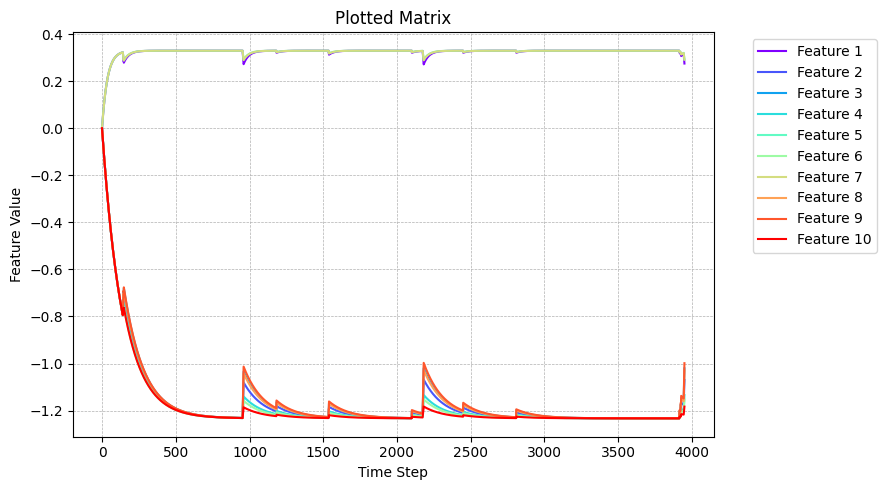

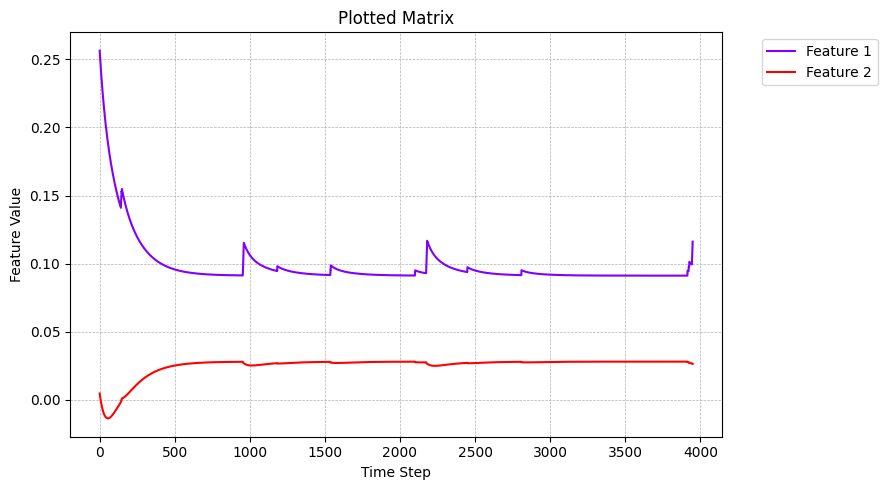

In [4]:
plot_matrix(ggaht_hss)
plot_matrix(ggaht_os)

In [5]:
# criterion = nn.CrossEntropyLoss() # Interestingly, doesn't work with single input, single output network
criterion = nn.MSELoss()

# optimizer = optim.SGD(ltc.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adadelta(ltc.parameters(), lr=0.01)
optimizer = optim.Adamax(ltc.parameters(), lr=0.1) # best optimizer thus far
# optimizer = optim.Adam(ltc.parameters(), lr=0.01)

ltc.advanced_train_model(datas_array=[ggaht_data, 
                                      tin_data,
                                      thai_data],
                        labels_array=[ggaht_labels, 
                                      tin_labels,
                                      thai_labels],
                        optimizer=optimizer,
                        criterion=criterion,
                        epochs=20)

[Epoch 1] loss: 0.06439
[Epoch 2] loss: 0.20254
[Epoch 3] loss: 0.18912
[Epoch 4] loss: 0.06835
[Epoch 5] loss: 0.04597
[Epoch 6] loss: 0.05657
[Epoch 7] loss: nan
[Epoch 8] loss: nan
[Epoch 9] loss: nan
[Epoch 10] loss: nan


KeyboardInterrupt: 

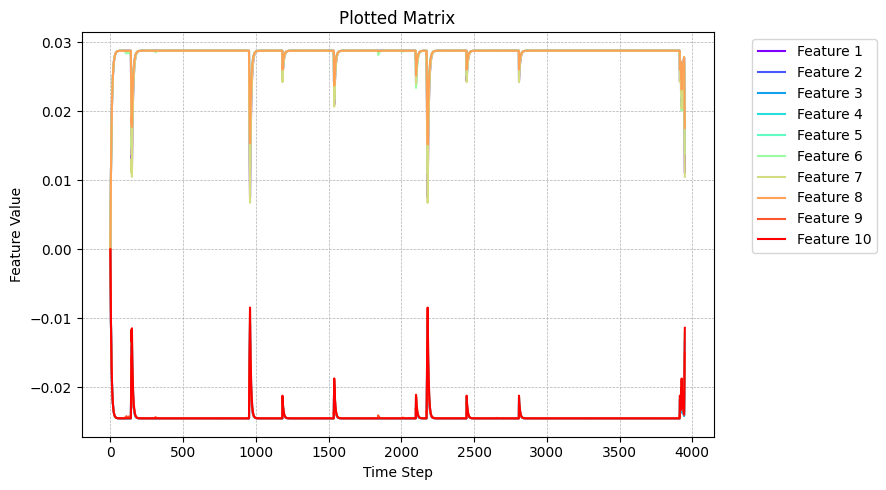

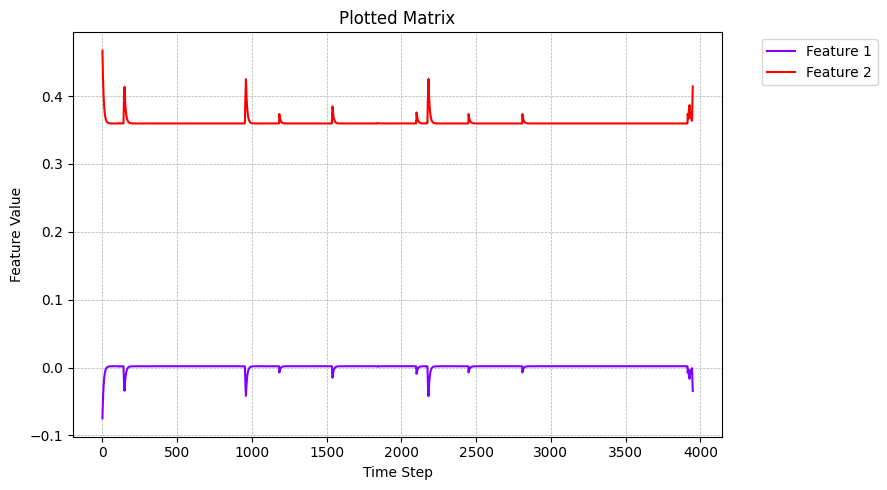

In [6]:
ggaht_hss_at, ggaht_os_at = ltc.passive_forward(ggaht_data)

plot_matrix(ggaht_hss_at)
plot_matrix(ggaht_os_at)

In [7]:
plot_in_time([ggaht_os, ggaht_labels, ggaht_os_at],
             labels = ["ggaht before training", "ggaht_labels", "gghat after training"])